In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal_tree = Tree(fc.sr.NMSSM_MX_700_MY_400)

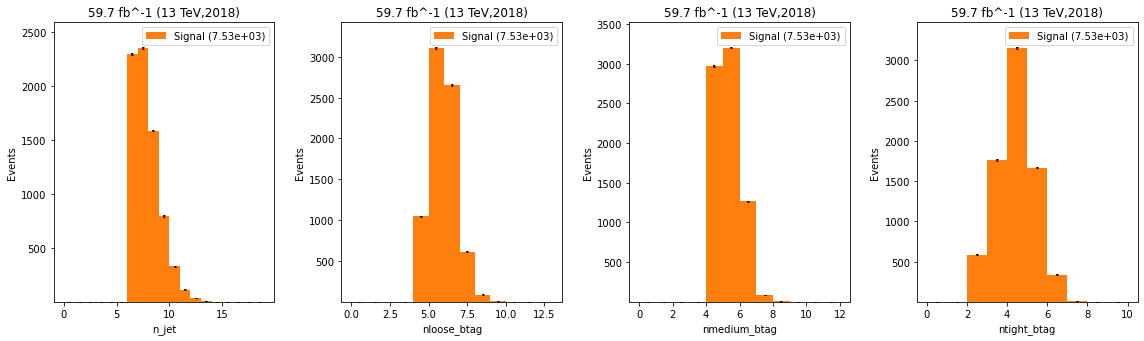

In [19]:
study.njets(signal_tree)

In [3]:
attrs = dict(labels=["Top 6 Jets","NN 6 Jets"],s_colors=["r","g"])

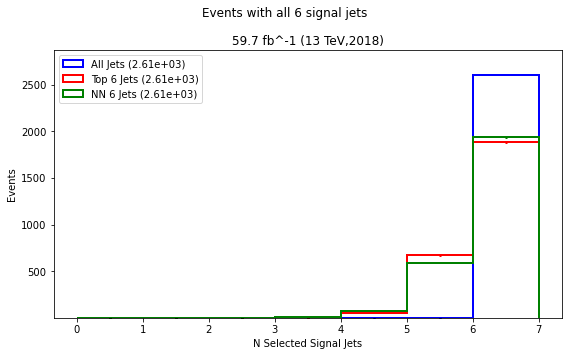

In [22]:
study.overlay(signal_tree,varlist=["nfound_presel","nfound_t6","nfound_nn"],labels=["All Jets","Top 6 Jets","NN 6 Jets"],ratio=0,title="Events with all 6 signal jets",s_colors=["b","r","g"],xlabel="N Selected Signal Jets",bins=range(8),masks=[signal_tree["nfound_presel"]==6])

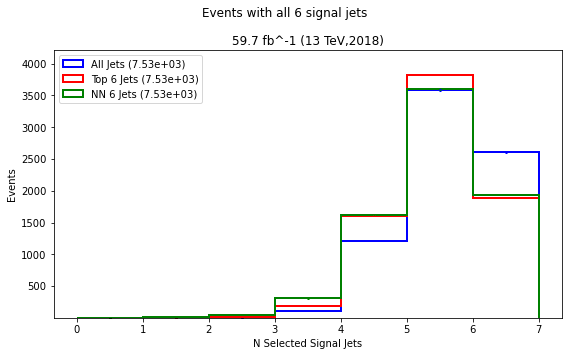

In [23]:
study.overlay(signal_tree,varlist=["nfound_presel","nfound_t6","nfound_nn"],labels=["All Jets","Top 6 Jets","NN 6 Jets"],ratio=0,title="Events with all 6 signal jets",s_colors=["b","r","g"],xlabel="N Selected Signal Jets",bins=range(8),)

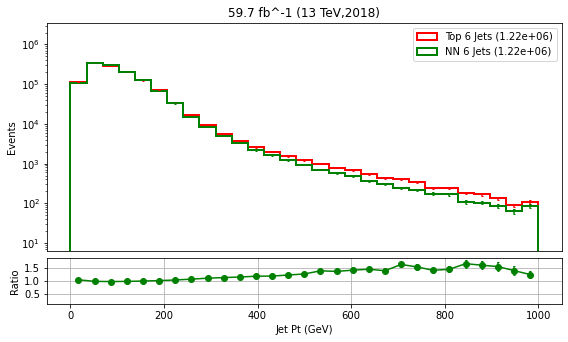

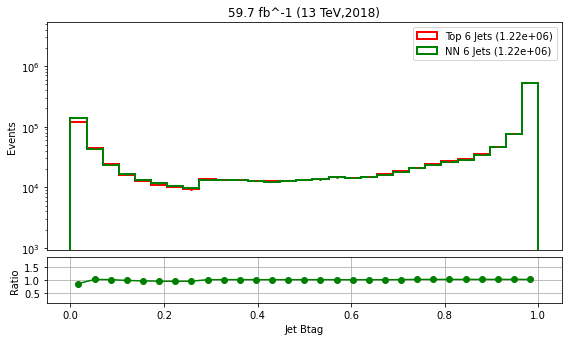

In [8]:
study.overlay(signal_tree,varlist=["t6_jet_pt","nn_jet_pt"],ratio=1,log=1,**varinfo['jet_pt'],**attrs)
study.overlay(signal_tree,varlist=["t6_jet_btag","nn_jet_btag"],ratio=1,log=1,**varinfo['jet_btag'],**attrs)

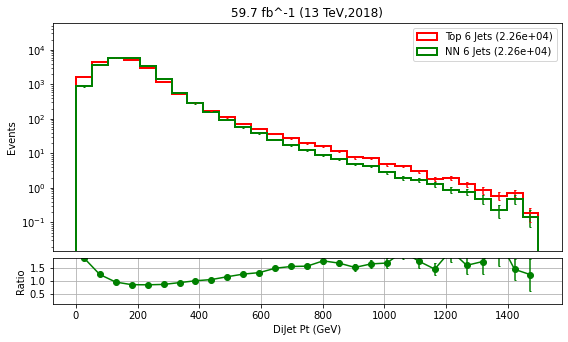

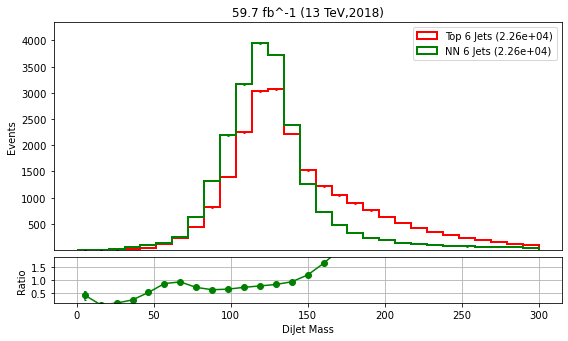

In [10]:
study.overlay(signal_tree,varlist=["t6_higgs_pt","nn_higgs_pt"],ratio=1,log=1,**varinfo['higgs_pt'],**attrs)
study.overlay(signal_tree,varlist=["t6_higgs_m","nn_higgs_m"],ratio=1,log=0,**varinfo['higgs_m'],**attrs)